# Kriging example

Since the global data base we used cannot be shared, we demonstrate using freely
available data from Assumpcao et al. (2013) for South America, how the codes
can be used.

For simplicity's sake we did not use two different categories here, but focused
on the continental area instead, by simply discarding all points where the Moho
depth is less than 30 km.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import clean_kriging
import sklearn.cluster as cluster

from func_dump import get_pairwise_geo_distance

import logging
logging.basicConfig(level=logging.DEBUG)

def test_cluster_size(point_data,max_size,do_plot=False,chosen_range=None,
        perc_levels=20):
    """Test effect of number of clusters on cluster radius and size
    """
    
    cluster_sizes = range(5,max_size,1)
    radius_1 = np.zeros((len(cluster_sizes),3))
    cluster_N = np.zeros((len(cluster_sizes),3))
    percentages = np.zeros((len(cluster_sizes),perc_levels+1))

    X = point_data
    Xsel = X
    pd = get_pairwise_geo_distance(Xsel[:,0],Xsel[:,1]) 

    for k,n_clusters in enumerate(cluster_sizes):
        model = cluster.AgglomerativeClustering(linkage='complete',
                                                affinity='precomputed',
                                                n_clusters=n_clusters)
        model.fit(pd)
        radius = np.zeros((n_clusters))
        cluster_members = np.zeros((n_clusters))
        for i,c in enumerate(np.unique(model.labels_)):
            ix = np.where(model.labels_==c)[0]
            radius[i] = 0.5*pd[np.ix_(ix,ix)].max()
            cluster_members[i] = np.sum(model.labels_==c)
        r1i,r1a,r1s = (radius.min(),radius.max(),radius.std())
        radius_1[k,0] = r1i
        radius_1[k,1] = r1a
        radius_1[k,2] = np.median(radius)
        percentages[k,:] = np.percentile(radius,np.linspace(0,100,perc_levels+1))
        
    radius_1 = radius_1*110.0
    percentages = percentages*110.0
    
    if do_plot:
        plt.plot(cluster_sizes,radius_1)

        for i in range(perc_levels):
            if i<perc_levels/2:
                alpha = (i+1)*2.0/perc_levels
            else:
                alpha = (perc_levels-i)*2.0/perc_levels
            plt.fill_between(cluster_sizes,percentages[:,i],percentages[:,i+1],
                alpha=alpha,facecolor='green',edgecolor='none')
    if not chosen_range is None:
        return cluster_sizes[np.argmin(np.abs(radius_1[:,2]-chosen_range))]


def cluster_map(krigor):
    """Visualize distribution spatial distribution of a cluster
    """
    fig = plt.figure(figsize=(7,11))

    Xsel = krigor.X
    
    model = krigor.cluster_results[0]
    n_clusters = model.n_clusters
    cmap = plt.cm.get_cmap("jet",n_clusters)
    
    clu = model.cluster_centers_
    pointsize = np.sqrt(np.bincount(model.labels_))
    
    for i in range(len(Xsel)):
        j = model.labels_[i]
        if (Xsel[i,0]*clu[j,0])<0 and np.abs(np.abs(clu[j,0])-180.0) < 10.0:
            continue
        plt.plot((Xsel[i,0],clu[j,0]),(Xsel[i,1],clu[j,1]),
                 color=cmap(model.labels_[i]),alpha=0.5)
    
    print clu.shape,n_clusters,pointsize.shape
    
    plt.scatter(clu[:,0],clu[:,1],7.5*pointsize,np.linspace(0,n_clusters,n_clusters),'s',
                     alpha=1.0,cmap=cmap,edgecolor='r',linewidth=1.5)
    
    plt.scatter(Xsel[:,0],Xsel[:,1],2,model.labels_,cmap=cmap,alpha=1.0,edgecolor='k')  
    plt.axis('equal')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.xlim([-90,-20])

## Data input
We load the file shipped together with this example. See the inside of the files for references to the sources.

In [3]:
point_data = np.loadtxt("Seismic_Moho_Assumpcao.txt",delimiter=",")
point_data[:,2] = -0.001*point_data[:,2] 

point_data = point_data[point_data[:,2]>30.0,:]

lon = np.arange(np.round(point_data[:,0].min()),np.round(point_data[:,0].max()+1),1)
lat = np.arange(np.round(point_data[:,1].min()),np.round(point_data[:,1].max()+1),1)

lonGrid,latGrid = np.meshgrid(lon,lat)

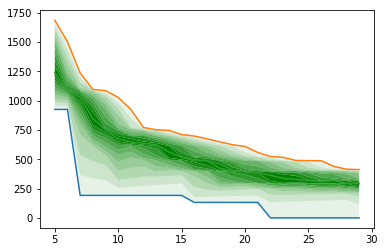

In [29]:
test_cluster_size(point_data,30,True)

## Prior specification
We want to use inverse gamma priors for nugget, sill and range. The inverse gamma distribution is defined in terms of the parameters $\alpha$ and $\beta$, which we derive here from a specified mean and variance. 

$$\mu = \mathrm{Mean} = \frac{\beta}{\alpha-1} \quad \text{and}\quad \sigma^2= \mathrm{var} = \frac{\beta^2}{(\alpha-1)^2(\alpha-2)}$$

Thus,

$$
\alpha = 2 + \frac{\mu^2}{\sigma^2} \quad \text{and}\quad\beta = \frac{\mu^3}{\sigma^2} + \mu
$$

The variable `moments` contains mean and variance for all nugget, sill and range. The last dimension of `moments` would be used, if there are different categories (i.e. ocean vs. continent), but in this example this is not required. 

In [4]:
moments = np.zeros((3,2,1))
moments[:,:,0] = np.array(((1.0,3.0**2),(40.0,40.0**2),(10.0,10.0**2)))
beta = moments[:,0,:]**3/moments[:,1,:]+moments[:,0,:]
alpha = 2 + moments[:,0,:]**2 / moments[:,1,:]

## Clustering
All important routines are contained in objects of the class `MLEKrigor`. Such an object is created by passing it longitude,latitude,value and category. In this example, all category values are simply zero. Any clustering algorithm from the scikit-learn package can be used. Any options contained in the dictionary `clusterOption` will be passed to the constructor.

After clustering, the covariance parameters for all clusters are determined (`krigor._fit_all_clusters`).

In [8]:
cat = np.ones((point_data.shape[0]),dtype=int)

krigor = clean_kriging.MLEKrigor(point_data[:,0],point_data[:,1],point_data[:,2],cat)
clusterOptions=[{'linkage':'complete','affinity':'precomputed','n_clusters':16}]

krigor._cluster_points(cluster.AgglomerativeClustering,options=clusterOptions,use_pd=True)
krigor._detect_dupes()
krigor._fit_all_clusters(minNugget=0.5,minSill=1.0,
    hyperpars=np.dstack((alpha,beta)),prior="inv_gamma",maxRange=None)

    
krigDict = {"threshold":1,"lambda_w":1.0,"minSill":1.0,
            "minNugget":0.5,
           "maxAbsError":4.0,"maxRelError":2.0,"badPoints":None,
           "hyperPars":np.dstack((alpha,beta)),"prior":"inv_gamma",
           "blocks":10}

clean_kriging.py:119: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)
clean_kriging.py:119: RuntimeWarning: divide by zero encountered in divide
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)
clean_kriging.py:119: RuntimeWarning: invalid value encountered in subtract
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)


(16L, 2L) 16 (16L,)


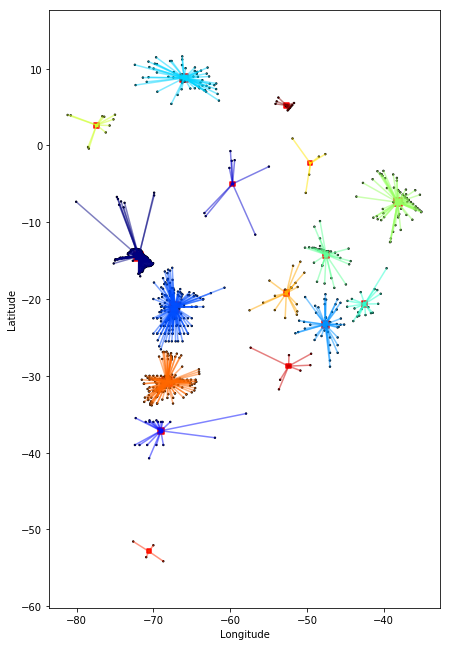

In [25]:
cluster_map(krigor)

In this map, the individual points are connected with lines to their respective cluster center

## Outlier detection
This is the most time-consuming step. The routine `jacknife` performs the hold-one-out cross validation to detect possible outliers. Two criteria are used to determine if a point is an outlier. 

1. The **absolute** prediction error needs to be 4 km or more.
2. The prediction error is twice as high as the estimated error.

This is controlled by the variables `maxAbsErr` and `maxRelErr` passed to the function `jacknife`. The third parameter ($\lambda_w$) controls how the covariance parameters are interpolated.

There are two rounds of outlier detection (see main text for explanation).

In [4]:
sigma1,new_chosen = krigor.jacknife(4.0,2.0,100.0)
krigor.chosen_points = new_chosen.copy()
krigor._fit_all_clusters(minNugget=0.5,minSill=1.0,
        hyperpars=krigDict["hyperPars"],prior="inv_gamma",maxRange=None)  
        
sigma2,new_new_chosen = krigor.jacknife(4.0,2.0,100.0)
krigor.chosen_points = new_new_chosen.copy()
krigor._fit_all_clusters(minNugget=0.5,minSill=1.0,
        hyperpars=krigDict["hyperPars"],prior="inv_gamma",maxRange=None)  

clean_kriging.py:119: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)
clean_kriging.py:119: RuntimeWarning: divide by zero encountered in divide
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)
clean_kriging.py:119: RuntimeWarning: invalid value encountered in subtract
  return np.sum(-(hyperpars[:,0]+1)*np.log(vals) - hyperpars[:,1]/vals)
INFO:root:Jacknife category 0 label 1
DEBUG:root:Jacknife_kriging_all_chosen: 0/146
DEBUG:root:Jacknife_kriging_all_chosen: 1/146
DEBUG:root:Jacknife_kriging_all_chosen: 2/146
DEBUG:root:Jacknife_kriging_all_chosen: 3/146
DEBUG:root:Jacknife_kriging_all_chosen: 4/146
DEBUG:root:Jacknife_kriging_all_chosen: 5/146
DEBUG:root:Jacknife_kriging_all_chosen: 6/146
DEBUG:root:Jacknife_kriging_all_chosen: 7/146
DEBUG:root:Jacknife_kriging_all_chosen: 8/146
DEBUG:root:Jacknife_kriging_all_chosen: 9/146
DEBUG:root:Jacknife_kriging_all_chosen: 10/146
DEBUG:root:Jackn

chosen 125 16 (16L,)
not chosen 125 16 (16L,) (16L,)


DEBUG:root:Jacknife_kriging_all_chosen: 21/40
DEBUG:root:Jacknife_kriging_all_chosen: 22/40
DEBUG:root:Jacknife_kriging_all_chosen: 23/40
DEBUG:root:Jacknife_kriging_all_chosen: 24/40
DEBUG:root:Jacknife_kriging_all_chosen: 25/40
DEBUG:root:Jacknife_kriging_all_chosen: 26/40
DEBUG:root:Jacknife_kriging_all_chosen: 27/40
DEBUG:root:Jacknife_kriging_all_chosen: 28/40
DEBUG:root:Jacknife_kriging_all_chosen: 29/40
DEBUG:root:Jacknife_kriging_all_chosen: 30/40
DEBUG:root:Jacknife_kriging_all_chosen: 31/40
DEBUG:root:Jacknife_kriging_all_chosen: 32/40
DEBUG:root:Jacknife_kriging_all_chosen: 33/40
DEBUG:root:Jacknife_kriging_all_chosen: 34/40
DEBUG:root:Jacknife_kriging_all_chosen: 35/40
DEBUG:root:Jacknife_kriging_all_chosen: 36/40
DEBUG:root:Jacknife_kriging_all_chosen: 37/40
DEBUG:root:Jacknife_kriging_all_chosen: 38/40
DEBUG:root:Jacknife_kriging_all_chosen: 39/40
INFO:root:Jacknife category 5 label 1
DEBUG:root:Jacknife_kriging_all_chosen: 0/58
DEBUG:root:Jacknife_kriging_all_chosen: 1/5

chosen 40 2 (2L,)
not chosen 40 2 (2L,) (2L,)


DEBUG:root:Jacknife_kriging_all_chosen: 15/58
DEBUG:root:Jacknife_kriging_all_chosen: 16/58
DEBUG:root:Jacknife_kriging_all_chosen: 17/58
DEBUG:root:Jacknife_kriging_all_chosen: 18/58
DEBUG:root:Jacknife_kriging_all_chosen: 19/58
DEBUG:root:Jacknife_kriging_all_chosen: 20/58
DEBUG:root:Jacknife_kriging_all_chosen: 21/58
DEBUG:root:Jacknife_kriging_all_chosen: 22/58
DEBUG:root:Jacknife_kriging_all_chosen: 23/58
DEBUG:root:Jacknife_kriging_all_chosen: 24/58
DEBUG:root:Jacknife_kriging_all_chosen: 25/58
DEBUG:root:Jacknife_kriging_all_chosen: 26/58
DEBUG:root:Jacknife_kriging_all_chosen: 27/58
DEBUG:root:Jacknife_kriging_all_chosen: 28/58
DEBUG:root:Jacknife_kriging_all_chosen: 29/58
DEBUG:root:Jacknife_kriging_all_chosen: 30/58
DEBUG:root:Jacknife_kriging_all_chosen: 31/58
DEBUG:root:Jacknife_kriging_all_chosen: 32/58
DEBUG:root:Jacknife_kriging_all_chosen: 33/58
DEBUG:root:Jacknife_kriging_all_chosen: 34/58
DEBUG:root:Jacknife_kriging_all_chosen: 35/58
DEBUG:root:Jacknife_kriging_all_ch

chosen 31 2 (2L,)
not chosen 31 2 (2L,) (2L,)


DEBUG:root:Jacknife_kriging_all_chosen: 8/62
DEBUG:root:Jacknife_kriging_all_chosen: 9/62
DEBUG:root:Jacknife_kriging_all_chosen: 10/62
DEBUG:root:Jacknife_kriging_all_chosen: 11/62
DEBUG:root:Jacknife_kriging_all_chosen: 12/62
DEBUG:root:Jacknife_kriging_all_chosen: 13/62
DEBUG:root:Jacknife_kriging_all_chosen: 14/62
DEBUG:root:Jacknife_kriging_all_chosen: 15/62
DEBUG:root:Jacknife_kriging_all_chosen: 16/62
DEBUG:root:Jacknife_kriging_all_chosen: 17/62
DEBUG:root:Jacknife_kriging_all_chosen: 18/62
DEBUG:root:Jacknife_kriging_all_chosen: 19/62
DEBUG:root:Jacknife_kriging_all_chosen: 20/62
DEBUG:root:Jacknife_kriging_all_chosen: 21/62
DEBUG:root:Jacknife_kriging_all_chosen: 22/62
DEBUG:root:Jacknife_kriging_all_chosen: 23/62
DEBUG:root:Jacknife_kriging_all_chosen: 24/62
DEBUG:root:Jacknife_kriging_all_chosen: 25/62
DEBUG:root:Jacknife_kriging_all_chosen: 26/62
DEBUG:root:Jacknife_kriging_all_chosen: 27/62
DEBUG:root:Jacknife_kriging_all_chosen: 28/62
DEBUG:root:Jacknife_kriging_all_chos

chosen 137 5 (5L,)
not chosen 137 5 (5L,) (5L,)


INFO:root:Jacknife category 0 label 1
DEBUG:root:Jacknife_kriging_all_chosen: 0/145
DEBUG:root:Jacknife_kriging_all_chosen: 1/145
DEBUG:root:Jacknife_kriging_all_chosen: 2/145
DEBUG:root:Jacknife_kriging_all_chosen: 3/145
DEBUG:root:Jacknife_kriging_all_chosen: 4/145
DEBUG:root:Jacknife_kriging_all_chosen: 5/145
DEBUG:root:Jacknife_kriging_all_chosen: 6/145
DEBUG:root:Jacknife_kriging_all_chosen: 7/145
DEBUG:root:Jacknife_kriging_all_chosen: 8/145
DEBUG:root:Jacknife_kriging_all_chosen: 9/145
DEBUG:root:Jacknife_kriging_all_chosen: 10/145
DEBUG:root:Jacknife_kriging_all_chosen: 11/145
DEBUG:root:Jacknife_kriging_all_chosen: 12/145
DEBUG:root:Jacknife_kriging_all_chosen: 13/145
DEBUG:root:Jacknife_kriging_all_chosen: 14/145
DEBUG:root:Jacknife_kriging_all_chosen: 15/145
DEBUG:root:Jacknife_kriging_all_chosen: 16/145
DEBUG:root:Jacknife_kriging_all_chosen: 17/145
DEBUG:root:Jacknife_kriging_all_chosen: 18/145
DEBUG:root:Jacknife_kriging_all_chosen: 19/145
DEBUG:root:Jacknife_kriging_all_

chosen 145 1 (1L,)
not chosen 145 1 (1L,) (1L,)
chosen 17 1 (1L,)
not chosen 17 1 (1L,) (1L,)


DEBUG:root:Jacknife_kriging_all_chosen: 1/125
DEBUG:root:Jacknife_kriging_all_chosen: 2/125
DEBUG:root:Jacknife_kriging_all_chosen: 3/125
DEBUG:root:Jacknife_kriging_all_chosen: 4/125
DEBUG:root:Jacknife_kriging_all_chosen: 5/125
DEBUG:root:Jacknife_kriging_all_chosen: 6/125
DEBUG:root:Jacknife_kriging_all_chosen: 7/125
DEBUG:root:Jacknife_kriging_all_chosen: 8/125
DEBUG:root:Jacknife_kriging_all_chosen: 9/125
DEBUG:root:Jacknife_kriging_all_chosen: 10/125
DEBUG:root:Jacknife_kriging_all_chosen: 11/125
DEBUG:root:Jacknife_kriging_all_chosen: 12/125
DEBUG:root:Jacknife_kriging_all_chosen: 13/125
DEBUG:root:Jacknife_kriging_all_chosen: 14/125
DEBUG:root:Jacknife_kriging_all_chosen: 15/125
DEBUG:root:Jacknife_kriging_all_chosen: 16/125
DEBUG:root:Jacknife_kriging_all_chosen: 17/125
DEBUG:root:Jacknife_kriging_all_chosen: 18/125
DEBUG:root:Jacknife_kriging_all_chosen: 19/125
DEBUG:root:Jacknife_kriging_all_chosen: 20/125
DEBUG:root:Jacknife_kriging_all_chosen: 21/125
DEBUG:root:Jacknife_kr

chosen 125 16 (16L,)
not chosen 125 16 (16L,) (16L,)


DEBUG:root:Jacknife_kriging_all_chosen: 19/40
DEBUG:root:Jacknife_kriging_all_chosen: 20/40
DEBUG:root:Jacknife_kriging_all_chosen: 21/40
DEBUG:root:Jacknife_kriging_all_chosen: 22/40
DEBUG:root:Jacknife_kriging_all_chosen: 23/40
DEBUG:root:Jacknife_kriging_all_chosen: 24/40
DEBUG:root:Jacknife_kriging_all_chosen: 25/40
DEBUG:root:Jacknife_kriging_all_chosen: 26/40
DEBUG:root:Jacknife_kriging_all_chosen: 27/40
DEBUG:root:Jacknife_kriging_all_chosen: 28/40
DEBUG:root:Jacknife_kriging_all_chosen: 29/40
DEBUG:root:Jacknife_kriging_all_chosen: 30/40
DEBUG:root:Jacknife_kriging_all_chosen: 31/40
DEBUG:root:Jacknife_kriging_all_chosen: 32/40
DEBUG:root:Jacknife_kriging_all_chosen: 33/40
DEBUG:root:Jacknife_kriging_all_chosen: 34/40
DEBUG:root:Jacknife_kriging_all_chosen: 35/40
DEBUG:root:Jacknife_kriging_all_chosen: 36/40
DEBUG:root:Jacknife_kriging_all_chosen: 37/40
DEBUG:root:Jacknife_kriging_all_chosen: 38/40
DEBUG:root:Jacknife_kriging_all_chosen: 39/40
INFO:root:Jacknife category 5 labe

chosen 40 2 (2L,)
not chosen 40 2 (2L,) (2L,)


DEBUG:root:Jacknife_kriging_all_chosen: 13/55
DEBUG:root:Jacknife_kriging_all_chosen: 14/55
DEBUG:root:Jacknife_kriging_all_chosen: 15/55
DEBUG:root:Jacknife_kriging_all_chosen: 16/55
DEBUG:root:Jacknife_kriging_all_chosen: 17/55
DEBUG:root:Jacknife_kriging_all_chosen: 18/55
DEBUG:root:Jacknife_kriging_all_chosen: 19/55
DEBUG:root:Jacknife_kriging_all_chosen: 20/55
DEBUG:root:Jacknife_kriging_all_chosen: 21/55
DEBUG:root:Jacknife_kriging_all_chosen: 22/55
DEBUG:root:Jacknife_kriging_all_chosen: 23/55
DEBUG:root:Jacknife_kriging_all_chosen: 24/55
DEBUG:root:Jacknife_kriging_all_chosen: 25/55
DEBUG:root:Jacknife_kriging_all_chosen: 26/55
DEBUG:root:Jacknife_kriging_all_chosen: 27/55
DEBUG:root:Jacknife_kriging_all_chosen: 28/55
DEBUG:root:Jacknife_kriging_all_chosen: 29/55
DEBUG:root:Jacknife_kriging_all_chosen: 30/55
DEBUG:root:Jacknife_kriging_all_chosen: 31/55
DEBUG:root:Jacknife_kriging_all_chosen: 32/55
DEBUG:root:Jacknife_kriging_all_chosen: 33/55
DEBUG:root:Jacknife_kriging_all_ch

chosen 55 3 (3L,)
not chosen 55 3 (3L,) (3L,)


DEBUG:root:Jacknife_kriging_all_chosen: 7/32
DEBUG:root:Jacknife_kriging_all_chosen: 8/32
DEBUG:root:Jacknife_kriging_all_chosen: 9/32
DEBUG:root:Jacknife_kriging_all_chosen: 10/32
DEBUG:root:Jacknife_kriging_all_chosen: 11/32
DEBUG:root:Jacknife_kriging_all_chosen: 12/32
DEBUG:root:Jacknife_kriging_all_chosen: 13/32
DEBUG:root:Jacknife_kriging_all_chosen: 14/32
DEBUG:root:Jacknife_kriging_all_chosen: 15/32
DEBUG:root:Jacknife_kriging_all_chosen: 16/32
DEBUG:root:Jacknife_kriging_all_chosen: 17/32
DEBUG:root:Jacknife_kriging_all_chosen: 18/32
DEBUG:root:Jacknife_kriging_all_chosen: 19/32
DEBUG:root:Jacknife_kriging_all_chosen: 20/32
DEBUG:root:Jacknife_kriging_all_chosen: 21/32
DEBUG:root:Jacknife_kriging_all_chosen: 22/32
DEBUG:root:Jacknife_kriging_all_chosen: 23/32
DEBUG:root:Jacknife_kriging_all_chosen: 24/32
DEBUG:root:Jacknife_kriging_all_chosen: 25/32
DEBUG:root:Jacknife_kriging_all_chosen: 26/32
DEBUG:root:Jacknife_kriging_all_chosen: 27/32
DEBUG:root:Jacknife_kriging_all_chose

chosen 32 1 (1L,)
not chosen 32 1 (1L,) (1L,)


DEBUG:root:Jacknife_kriging_all_chosen: 8/61
DEBUG:root:Jacknife_kriging_all_chosen: 9/61
DEBUG:root:Jacknife_kriging_all_chosen: 10/61
DEBUG:root:Jacknife_kriging_all_chosen: 11/61
DEBUG:root:Jacknife_kriging_all_chosen: 12/61
DEBUG:root:Jacknife_kriging_all_chosen: 13/61
DEBUG:root:Jacknife_kriging_all_chosen: 14/61
DEBUG:root:Jacknife_kriging_all_chosen: 15/61
DEBUG:root:Jacknife_kriging_all_chosen: 16/61
DEBUG:root:Jacknife_kriging_all_chosen: 17/61
DEBUG:root:Jacknife_kriging_all_chosen: 18/61
DEBUG:root:Jacknife_kriging_all_chosen: 19/61
DEBUG:root:Jacknife_kriging_all_chosen: 20/61
DEBUG:root:Jacknife_kriging_all_chosen: 21/61
DEBUG:root:Jacknife_kriging_all_chosen: 22/61
DEBUG:root:Jacknife_kriging_all_chosen: 23/61
DEBUG:root:Jacknife_kriging_all_chosen: 24/61
DEBUG:root:Jacknife_kriging_all_chosen: 25/61
DEBUG:root:Jacknife_kriging_all_chosen: 26/61
DEBUG:root:Jacknife_kriging_all_chosen: 27/61
DEBUG:root:Jacknife_kriging_all_chosen: 28/61
DEBUG:root:Jacknife_kriging_all_chos

chosen 61 1 (1L,)
not chosen 61 1 (1L,) (1L,)
chosen 6 4 (4L,)
not chosen 6 4 (4L,) (4L,)
chosen 4 1 (1L,)
not chosen 4 1 (1L,) (1L,)


DEBUG:root:Jacknife_kriging_all_chosen: 1/131
DEBUG:root:Jacknife_kriging_all_chosen: 2/131
DEBUG:root:Jacknife_kriging_all_chosen: 3/131
DEBUG:root:Jacknife_kriging_all_chosen: 4/131
DEBUG:root:Jacknife_kriging_all_chosen: 5/131
DEBUG:root:Jacknife_kriging_all_chosen: 6/131
DEBUG:root:Jacknife_kriging_all_chosen: 7/131
DEBUG:root:Jacknife_kriging_all_chosen: 8/131
DEBUG:root:Jacknife_kriging_all_chosen: 9/131
DEBUG:root:Jacknife_kriging_all_chosen: 10/131
DEBUG:root:Jacknife_kriging_all_chosen: 11/131
DEBUG:root:Jacknife_kriging_all_chosen: 12/131
DEBUG:root:Jacknife_kriging_all_chosen: 13/131
DEBUG:root:Jacknife_kriging_all_chosen: 14/131
DEBUG:root:Jacknife_kriging_all_chosen: 15/131
DEBUG:root:Jacknife_kriging_all_chosen: 16/131
DEBUG:root:Jacknife_kriging_all_chosen: 17/131
DEBUG:root:Jacknife_kriging_all_chosen: 18/131
DEBUG:root:Jacknife_kriging_all_chosen: 19/131
DEBUG:root:Jacknife_kriging_all_chosen: 20/131
DEBUG:root:Jacknife_kriging_all_chosen: 21/131
DEBUG:root:Jacknife_kr

chosen 131 11 (11L,)
not chosen 131 11 (11L,) (11L,)
Solving kriging system for category 1 with no. points 3149 677 


## Interpolation
To run the actual interpolation, the `predict` method of the `MLEKrigor` is used. It takes, longitude, latitude and category as main input. In addition, $\lambda_w$ needs to be specified.  This mainly affects the obtained uncertainties. If desired, the full covariance matrix can also be calculated, but due to memory constraints, by default only the variance (main diagonal) is computed. 

Note that `predict` does not respect the shape of the input points and the outputs needs to be reshaped. Furtheremore, the **variance** of the error is returned (to be compatible with the full covariance case) not the standard deviation!

In [32]:
cat_grid = np.ones(lonGrid.shape,dtype=int)

pred,krigvar,predPars = krigor.predict(lonGrid.flatten(),latGrid.flatten(),cat_grid.flatten(),
                                       lambda_w=1000.0,get_covar=False)

pred = pred.reshape(lonGrid.shape)
krigvar = krigvar.reshape(lonGrid.shape)

Solving kriging system for category 1 with no. points 3149 699 


(-81.0, -35.0, -54.0, 12.0)

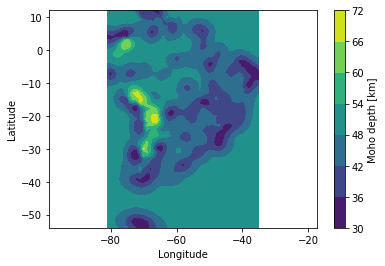

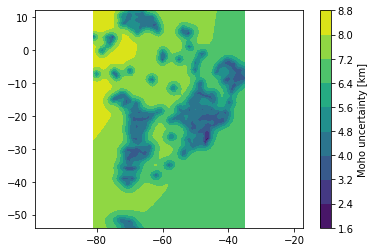

In [33]:
plt.figure()
plt.contourf(lonGrid,latGrid,pred)
cbar = plt.colorbar()
cbar.set_label('Moho depth [km]')
plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.figure()
plt.contourf(lonGrid,latGrid,np.sqrt(krigvar))
cbar = plt.colorbar()
cbar.set_label('Moho uncertainty [km]')
plt.axis('equal')

Note that in this case, one should not interpret results in the oceanic domain, since they were excluded from the interpolation.